In [1]:
import sqlite3
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import geopandas as gpd
from shapely.geometry import Point

Data Source:

Hammarström, Harald & Haspelmath, Martin & Forkel, Robert. 2017.
Glottolog 3.0. Jena: Max Planck Institute for the Science of Human History.

Kaggle Dataset Link:

https://www.kaggle.com/datasets/rtatman/world-language-family-map/data

In [2]:
df1 = pd.read_csv('languages-and-dialects-geo.csv')

In [3]:
engine = create_engine('sqlite://', echo=False)
df1.to_sql('languages', con=engine, index=False)
query = "SELECT * FROM languages WHERE level='language'"
cleaned_df1 = pd.read_sql_query(query, con=engine)

In [4]:
df1.head()

,glottocode,name,isocodes,level,macroarea,latitude,longitude
0,aala1237,Aalawa,NaN,dialect,Papunesia,NaN,NaN
1,aant1238,Aantantara,NaN,dialect,Papunesia,NaN,NaN
2,aari1239,Aari,aiw,language,Africa,5.95034,36.5721
3,aari1240,Aariya,aay,language,Eurasia,NaN,NaN
4,aasa1238,Aasax,aas,language,Africa,-4.00679,36.8648


In [5]:
latitudes = cleaned_df1['latitude'].values
longitudes = cleaned_df1['longitude'].values

<ipython-input-8-82b3e24ea813>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  self.world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


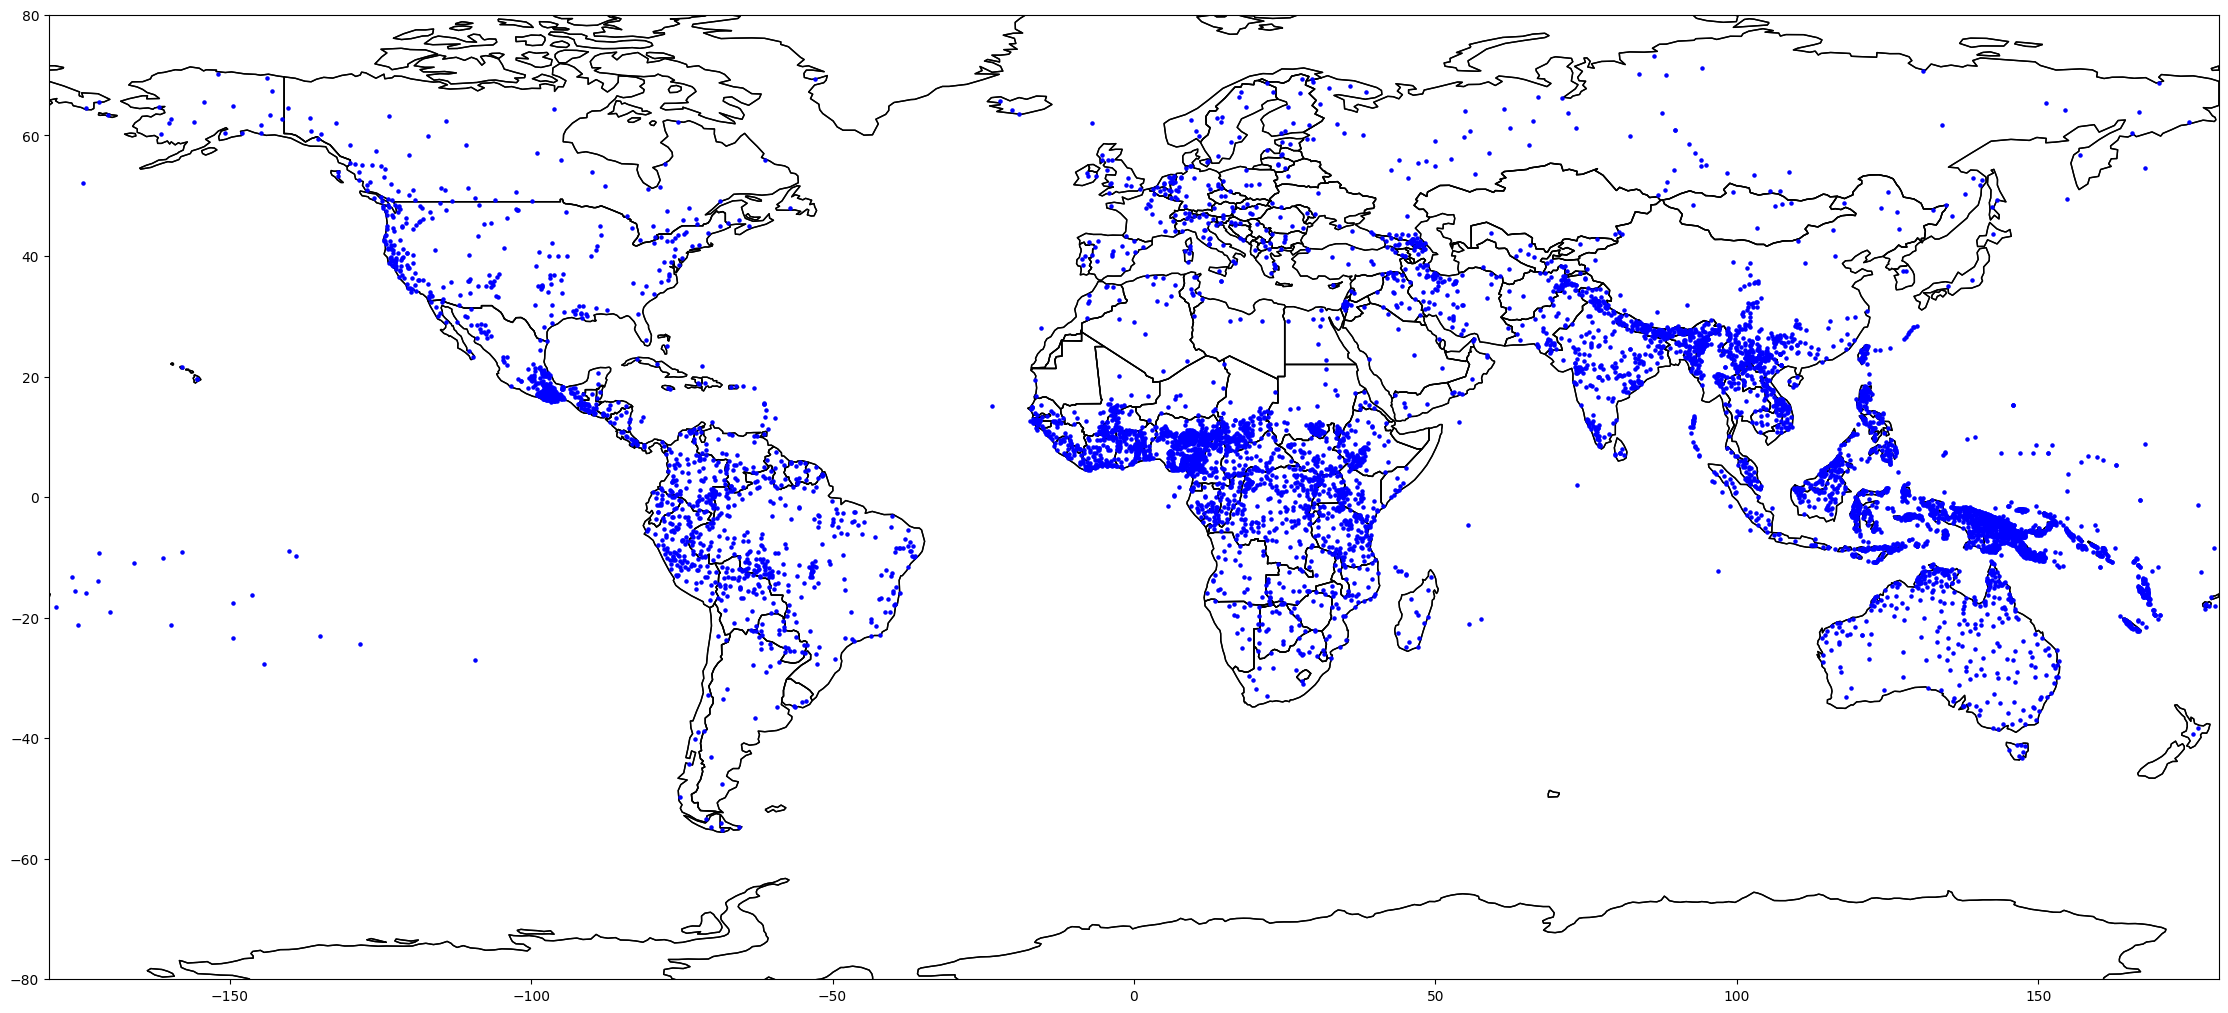

In [8]:
class LanguageLocationPlotter:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.geometry = [Point(xy) for xy in zip(self.dataframe['longitude'], self.dataframe['latitude'])]
        self.gdf = gpd.GeoDataFrame(self.dataframe, geometry=self.geometry)
        self.world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    def create_plot(self, figsize=(28, 21), point_color='blue', point_size=5, world_color='white', edge_color='black', linewidth=1):
        fig, ax = plt.subplots(figsize=figsize)
        self.world.boundary.plot(ax=ax, linewidth=linewidth, edgecolor=edge_color)
        self.world.plot(ax=ax, color=world_color, edgecolor=edge_color)
        self.gdf.plot(ax=ax, color=point_color, markersize=point_size, zorder=5)
        ax.set_xlim([-180, 180])
        ax.set_ylim([-80, 80])
        plt.show()

if __name__ == "__main__":
    plotter = LanguageLocationPlotter(cleaned_df1)
    plotter.create_plot()

# Where are the extinct languages located?

<ipython-input-9-525854745eb1>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  self.world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Unique statuses: ['safe' 'extinct' 'critically endangered' 'definitely endangered'
 'vulnerable' 'severely endangered']


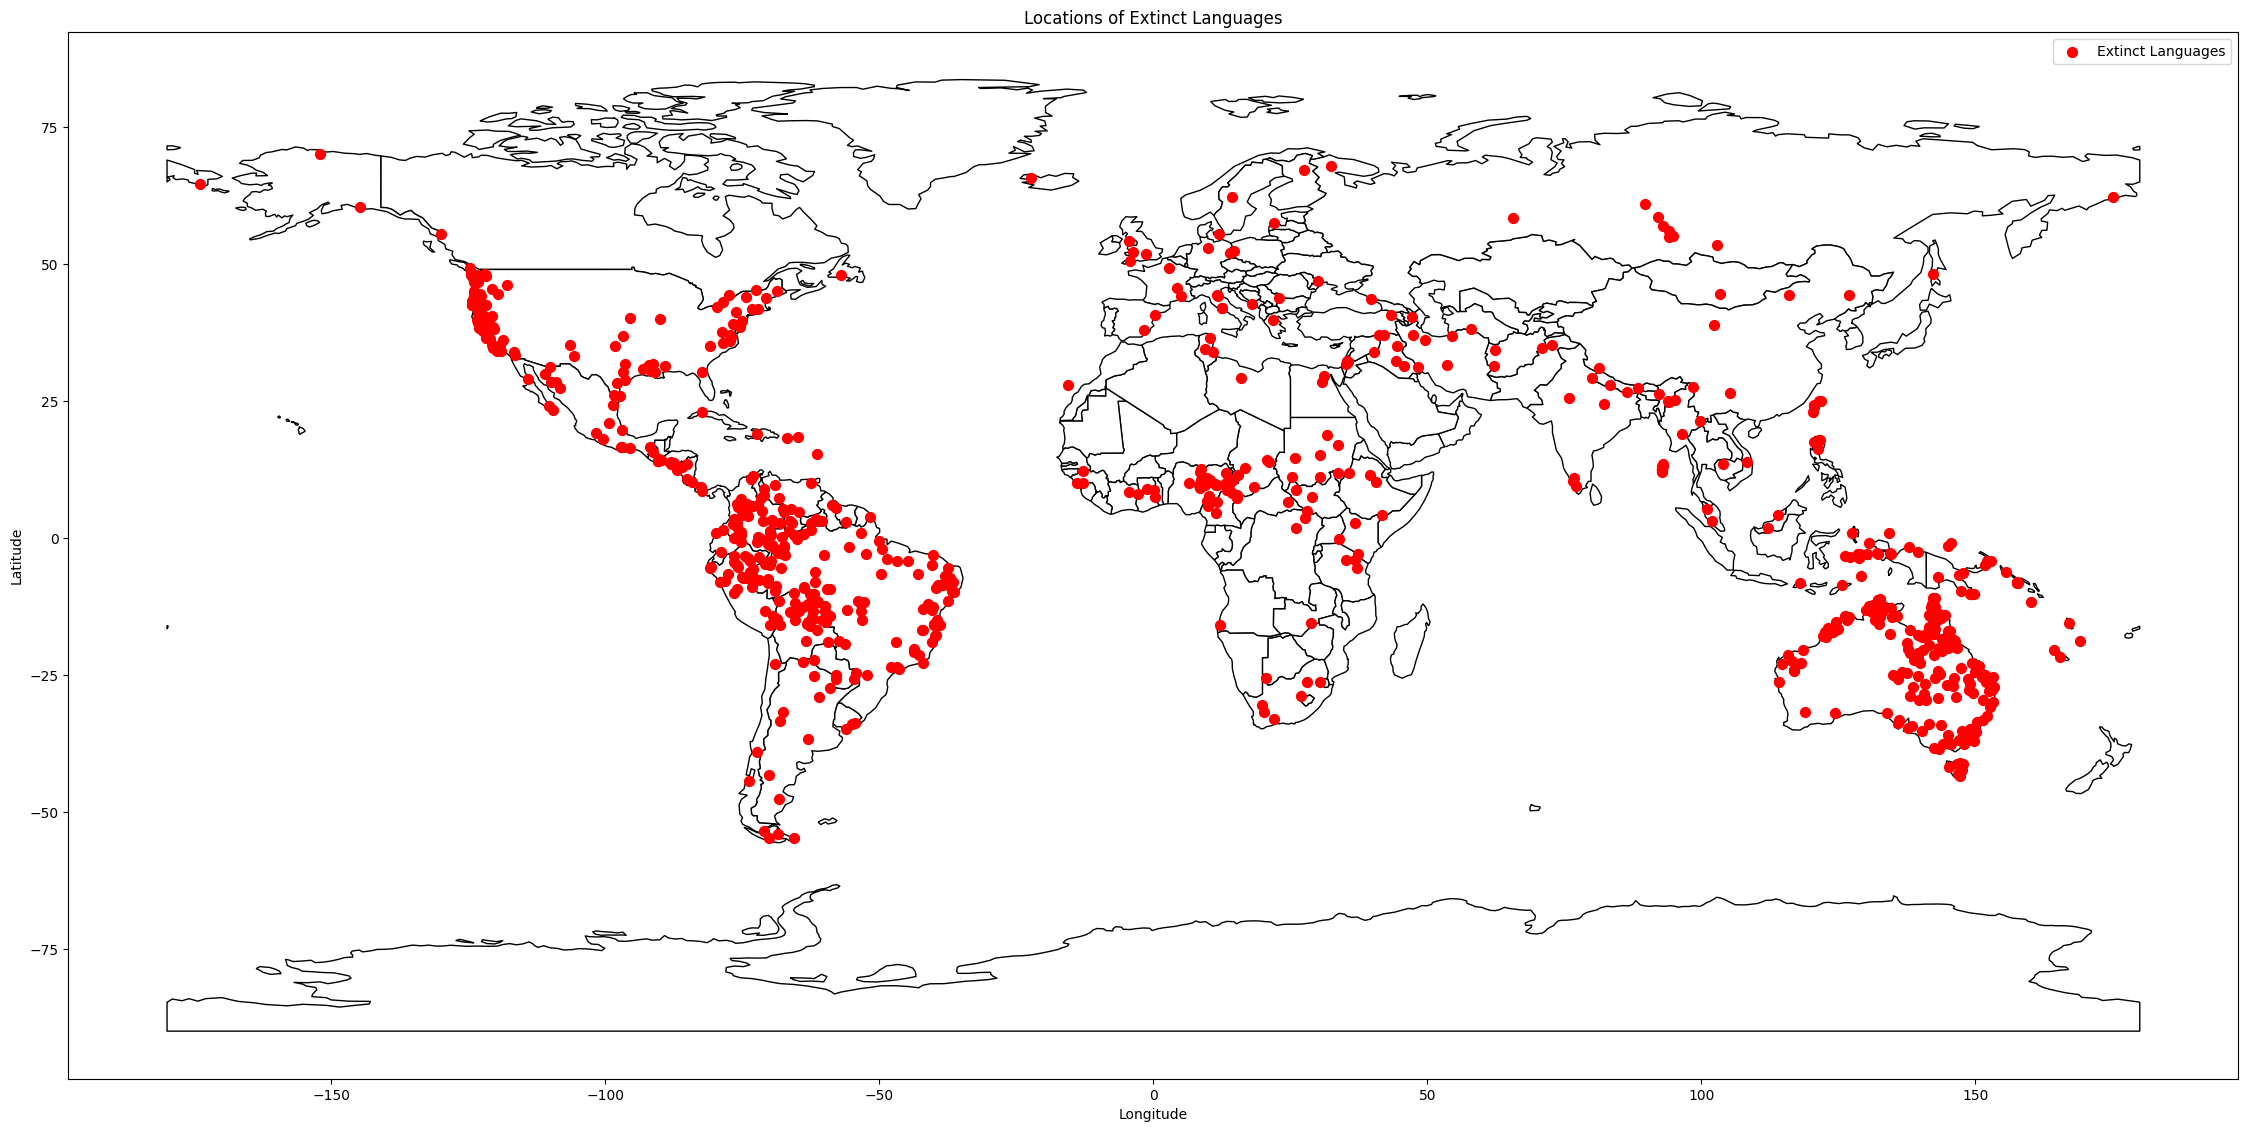

In [9]:
class ExtinctLanguagesPlotter:
    def __init__(self, csv_file):
        self.dataframe = pd.read_csv(csv_file)
        self.geometry = [Point(xy) for xy in zip(self.dataframe['longitude'], self.dataframe['latitude'])]
        self.gdf = gpd.GeoDataFrame(self.dataframe, geometry=self.geometry)
        self.world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    def plot_extinct_languages(self, figsize=(28, 21), point_color='red', point_size=50, world_color='white', edge_color='black'):
        print("Unique statuses:", self.gdf['status'].unique())

        extinct_gdf = self.gdf[self.gdf['status'] == 'extinct']

        fig, ax = plt.subplots(figsize=figsize)
        self.world.plot(ax=ax, color=world_color, edgecolor=edge_color)

        if not extinct_gdf.empty:
            extinct_gdf.plot(ax=ax, color=point_color, markersize=point_size, label='Extinct Languages', marker='o')
            plt.legend()
        else:
            print("No extinct languages found.")

        plt.title('Locations of Extinct Languages')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

if __name__ == "__main__":
    plotter = ExtinctLanguagesPlotter('languoid.csv')
    plotter.plot_extinct_languages()

#Clustering Language Families

In [11]:
from sklearn.cluster import DBSCAN
import numpy as np

<ipython-input-15-2d549e6e1d8e>:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  self.world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


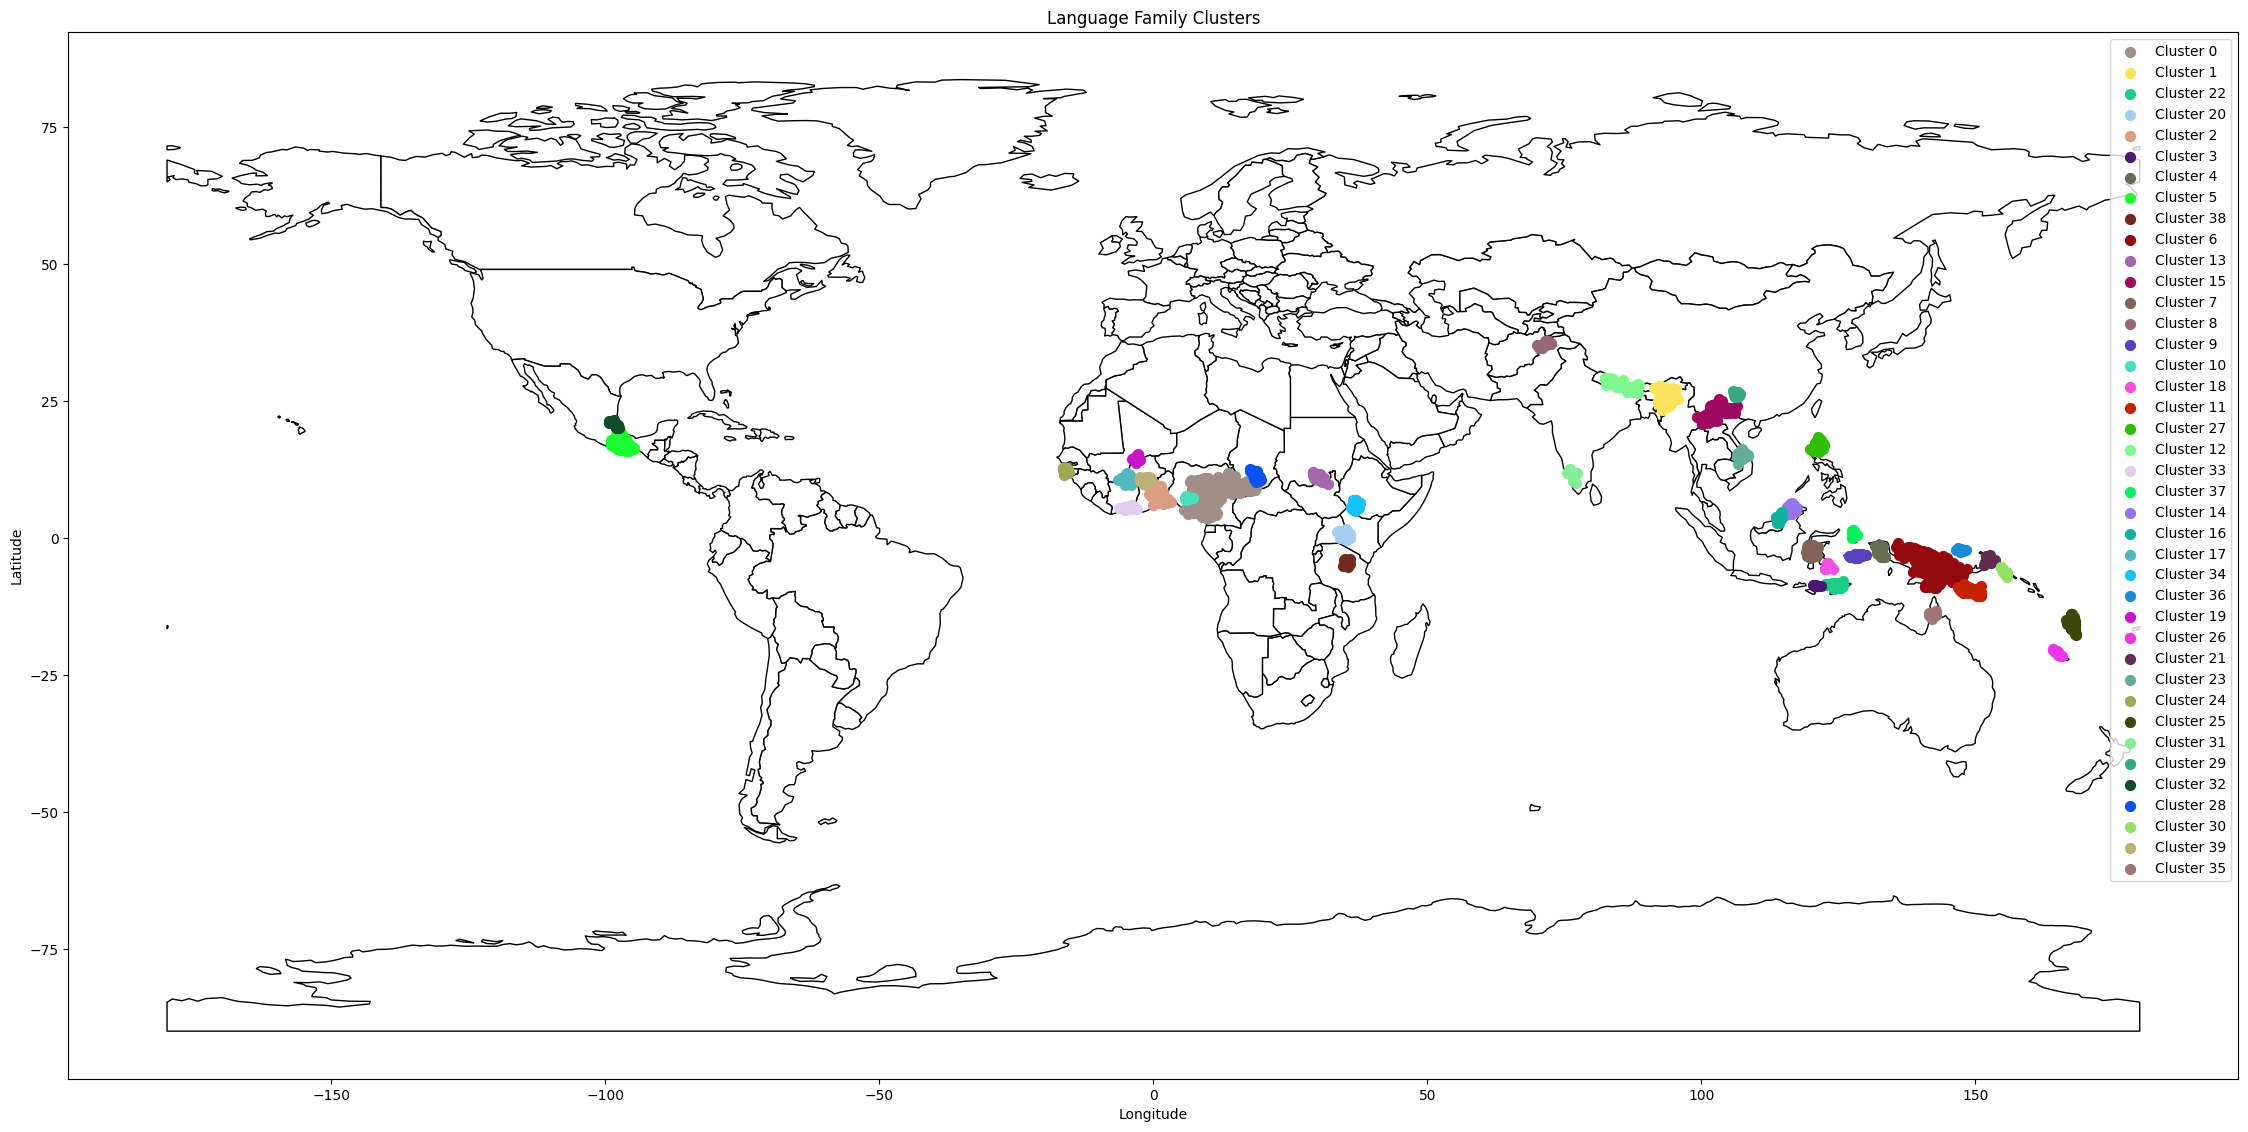

In [15]:
class LanguageFamilyPlotter:
    def __init__(self, csv_file, sample_fraction=0.5, random_state=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe.dropna(subset=['longitude', 'latitude'], inplace=True)  # Drop NaN values
        self.dataframe = self.dataframe.sample(frac=sample_fraction, random_state=random_state)  # Randomly sample data
        self.geometry = [Point(xy) for xy in zip(self.dataframe['longitude'], self.dataframe['latitude'])]
        self.gdf = gpd.GeoDataFrame(self.dataframe, geometry=self.geometry)
        self.world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    def plot_clusters(self, eps=0.5, min_samples=5, figsize=(28, 21), world_color='white', edge_color='black', show_noise=False):
        coordinates = self.gdf[['longitude', 'latitude']].values
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
        self.gdf['cluster'] = db.labels_

        fig, ax = plt.subplots(figsize=figsize)
        self.world.plot(ax=ax, color=world_color, edgecolor=edge_color)

        unique_clusters = self.gdf['cluster'].unique()
        for cluster in unique_clusters:
            if cluster == -1:
                if show_noise:
                    color = 'k'  # Black color for noise
                    label = 'Noise'
                else:
                    continue  # Skip plotting noise
            else:
                color = np.random.rand(3,)
                label = f'Cluster {cluster}'
            cluster_points = self.gdf[self.gdf['cluster'] == cluster]
            cluster_points.plot(ax=ax, color=color, markersize=50, label=label, marker='o')

        plt.legend()
        plt.title('Language Family Clusters')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

# Usage example
if __name__ == "__main__":
    plotter = LanguageFamilyPlotter('languoid.csv', sample_fraction=0.5, random_state=42)
    plotter.plot_clusters(eps=1.0, min_samples=10, show_noise=False)